# Домашняя работа №5.

* Написать модель (с помощью выдвижения гипотез или применяя модель Random Forest) на датасет больных сердечными болезнями.

In [47]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline
from sklearn.metrics import classification_report
import researchpy as rp 

In [48]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Данный датасет разобран в начале лекции 5. Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравнваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима)

Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр **максимально** влияет на болезнь.

* Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

In [50]:
# Построим модель Random Forest, чтобы оценить какие факторы оказывают наибольшее влияние на болезнь сердца.
output_y = data
input_x = data

In [51]:
# Таргет значение представим ввиде наименований классов.

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

gender         45529
cholesterol    18814
gluc            3573
active          1228
smoke            457
cardio           174
alco             127
id                97
ap_hi              1
dtype: int64


In [52]:
# Выделим из датасета тренировочные и тестовые данные. 

from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.2)

In [53]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

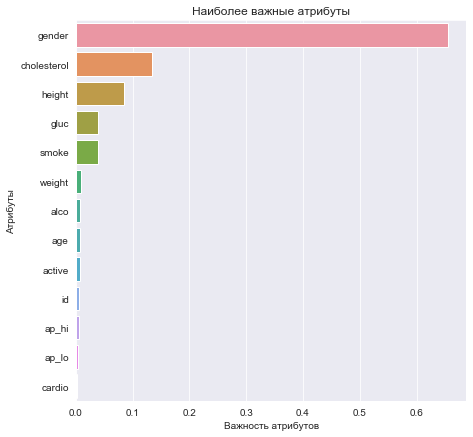

In [54]:
headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [55]:
# Classification report

model_pred = model.predict(X_test_22)
model_score = (model.score(X_test_22, y_test_22))*100

print(classification_report(y_test_22, model_pred))
print(f'Точность предсказания модели порядка {model_score:.2f}%')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00      3730
           5       1.00      1.00      1.00      9136
           6       1.00      1.00      1.00       721
           7       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        89

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000

Точность предсказания модели порядка 100.00%


## Протестируем гипотезу, что люди с повышенным весом болеют чаще

Есть статистика со средним весом людей по странам - https://bigpicture.ru/?p=800491
Допустим, что наш датасет из Германии.

Средний вес жителей Германии:
- Мужчины — 82 кг.
- Женщины — 68 кг.

**Гипотеза**

Люди, чей вес превышает 15% от нормы болеют сердечными болезнями чаще.

In [70]:
# Посчитаем норму веса для мужчин и женщин

male_f = data.loc[data['weight'] > (82*1.15), :]
female_f = data.loc[data['weight'] > (68*1.15), :]

male_s = data.loc[data['weight'] <= (82*1.15), :]
female_s = data.loc[data['weight'] <= (68*1.15), :]


female_fat  = female_f[female_f['gender']==1].cardio
female_skinny = female_s[female_s['gender']==1].cardio

male_fat  = male_f[data['gender']==2].cardio
male_skinny = male_s[male_s['gender']==2].cardio


C:\Users\gaill\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [71]:
descriptives, results = rp.ttest(female_fat, female_skinny)

In [72]:
print(descriptives)
print('_______________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  12991.0  0.617197  0.486090  0.004265   0.608837  0.625556
1    cardio  32539.0  0.448631  0.497362  0.002757   0.443227  0.454035
2  combined  45530.0  0.496727  0.499995  0.002343   0.492135  0.501320
_______________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.1686
1            Degrees of freedom =   45528.0000
2                             t =      32.8674
3         Two side test p value =       0.0000
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.3411
7                     Hedge's g =       0.3411
8                 Glass's delta =       0.3468
9                             r =       0.1522


Среднее значение для женщин с повышенным весом значительно выше, чем в среднем у женщин. 
Two side test p value =       0.0000 (меньше <0.05). Можно сделать вывод, что выборки не совпадают.

Проверим влияет ли вес мужчин на наличие сердечной болезни.

In [73]:
descriptives, results = rp.ttest(male_fat, male_skinny)

In [74]:
print(descriptives)
print('_______________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   2744.0  0.665452  0.471918  0.009009   0.647787  0.683117
1    cardio  21726.0  0.484995  0.499786  0.003391   0.478349  0.491641
2  combined  24470.0  0.505231  0.499983  0.003196   0.498966  0.511496
_______________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.1805
1            Degrees of freedom =   24468.0000
2                             t =      17.9312
3         Two side test p value =       0.0000
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.3633
7                     Hedge's g =       0.3633
8                 Glass's delta =       0.3824
9                             r =       0.1139


Для мужчин с повышенным весом среднее значение еще больше отличается от среднего значения всей выборки - 66% болеют. Two side test p value = 0.0000 (меньше <0.05). Можно сделать вывод, что выборки не совпадают.

## Посмотрим влияние глюкозы на наличие болезни сердца

In [75]:
# Сделаем 2 выборки с разным уровнем глюкозы

gluc_1 = data[data['gluc']==1].cardio
gluc_2 = data[data['gluc']==2].cardio

In [68]:
descriptives, results = rp.ttest(gluc_1, gluc_2)

In [69]:
print(descriptives)
print('_______________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  59479.0  0.480590  0.499627  0.002049   0.476574  0.484605
1    cardio   5190.0  0.593064  0.491310  0.006820   0.579694  0.606433
2  combined  64669.0  0.489616  0.499896  0.001966   0.485763  0.493469
_______________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1125
1            Degrees of freedom =   64667.0000
2                             t =     -15.5739
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.2254
7                     Hedge's g =      -0.2254
8                 Glass's delta =      -0.2251
9                             r =       0.0611


Так как среднее значение первой группы намного ближе к среднему значению, можно предположить, что выборки не являются равными по количеству элементов и в группе gluc_1 намного больше элементов, чем во второй.
Различие в двух выборках значительное. Можно предположить, что уровень глюкозы связан с наличием или отсутствием болезни сердца.

***
Я не поняла тему. Как читать таблицу и что значат ее параметры.